<a href="https://colab.research.google.com/github/amatoluca88/Reducing-Complexity-in-Diabetes-Classification/blob/main/Benchmarking_classifiers_Random_Forest_vs_XGBoost_vs_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reducing Complexity in Diabetes Classification

---



In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uciml_pima_indians_diabetes_database_path = kagglehub.dataset_download('uciml/pima-indians-diabetes-database')

print('Data source import complete.')


Using Colab cache for faster access to the 'pima-indians-diabetes-database' dataset.
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


____

In [3]:
df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


----
# Dataset

Il dataset contiene misurazioni cliniche di pazienti femminili, tra cui:

- Pregnancies
- Glucose
- BloodPressure
- SkinThickness
- Insulin
- BMI
- DiabetesPedigreeFunction
- Age

La variabile target `Outcome` indica la presenza (1) o assenza (0) di diabete.

Analizziamo la distribuzione delle variabili, la presenza di valori anomali (es. zeri in variabili fisiologiche) e la correlazione tra le feature.

----
# Missing values

In [4]:
df.shape

(768, 9)

In [5]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


----
# Preprocessing

## Campionamento

In [6]:
X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].values
y = df['Outcome'].values

In [7]:
#split and standard

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=0)

----
# Modelli

## Random Forest

###Training e valutazione

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
from sklearn.model_selection import train_test_split

# 1) Train-test split
# X = feature, y = target. stratify=y mantiene proporzione classi
# train_size=0.8 → 80% training, 20% test

X = df.iloc[:, :-1].values   # tutte le colonne tranne l’ultima
y = df.iloc[:, -1].values    # ultima colonna = target
feat_labels = df.columns[:-1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=0, stratify=y
)

# 2) Addestramento Random Forest
# RandomForestClassifier: n_estimators=1000, random_state=0
# Non serve standardizzare i dati (alberi basati su soglie)
# fit sul training set

forest = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight='balanced')
forest.fit(X_train, y_train)

# 3) Valutazione sul test
# predict: classi previste
# predict_proba[:,1]: probabilità per ROC / soglia personalizzata
# Accuracy, Classification Report, Confusion Matrix

y_pred = forest.predict(X_test)
y_proba = forest.predict_proba(X_test)[:, 1]  # per ROC/AUC

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8116883116883117

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       100
           1       0.79      0.63      0.70        54

    accuracy                           0.81       154
   macro avg       0.81      0.77      0.78       154
weighted avg       0.81      0.81      0.81       154



#### Risultati

**Accuracy:** 0.81 → circa l'81% delle predizioni complessive è corretto.

**Classe 0 (negativa):**

* **Precision:** 0.82 → predizioni 0 corrette l’82% delle volte
* **Recall:** 0.91 → cattura il 91% dei veri 0 (ottimo)
* **F1-score:** 0.86 → buon equilibrio precision/recall

**Classe 1 (positiva):**

* **Precision:** 0.79 → predizioni 1 corrette il 79% delle volte
* **Recall:** 0.63 → cattura solo il 63% dei veri 1
* **F1-score:** 0.70 → discreto ma migliorabile

**Macro avg:**

* Media semplice tra le due classi, mostra leggero squilibrio tra le classi

**Weighted avg:**

* Media pesata in base al numero di esempi per classe, simile all’accuracy complessiva

**Interpretazione:**

* Il modello riconosce bene la classe 0
* La classe 1 ha recall più bassa → alcuni positivi non vengono catturati
* Azioni possibili: regolare soglia di decisione, bilanciare le classi, usare oversampling/undersampling.

----

### Confusion Matrix grafica


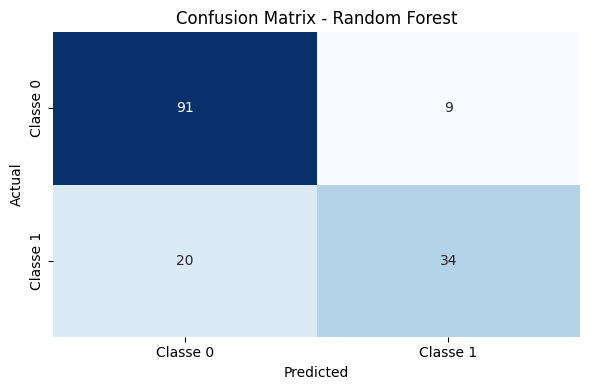

In [9]:
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Classe 0", "Classe 1"],
            yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

#### Risultati:

**Distribuzione predizioni:**
- **Classe 0 (negativa):**
  - **Vero negativo (TN):** 91 → correttamente classificati come 0
  - **Falso positivo (FP):** 9 → errore: classificati come 1
- **Classe 1 (positiva):**
  - **Falso negativo (FN):** 20 → errore: classificati come 0
  - **Vero positivo (TP):** 34 → correttamente classificati come 1

**Metriche chiave (derivabili):**
- **Accuracy:** (91 + 34) / 154 ≈ **0.81** → conferma l’81% di predizioni corrette
- **Precision Classe 1:** 34 / (34 + 9) ≈ **0.79**
- **Recall Classe 1:** 34 / (34 + 20) ≈ **0.63**
- **F1-score Classe 1:** ≈ **0.70**

**Interpretazione:**
- Il modello riconosce molto bene la **Classe 0** → pochi falsi positivi
- La **Classe 1** è meno riconosciuta → alto numero di falsi negativi
- Potenziale **squilibrio di classe** o soglia decisionale troppo conservativa

**Suggerimenti:**
- Valutare **regolazione della soglia di classificazione** per migliorare il recall della Classe 1
- Considerare **tecniche di bilanciamento** (es. SMOTE, class weights)
- Analizzare l’impatto clinico dei falsi negativi → importante se il modello è usato in ambito sanitario


### Feature Importances

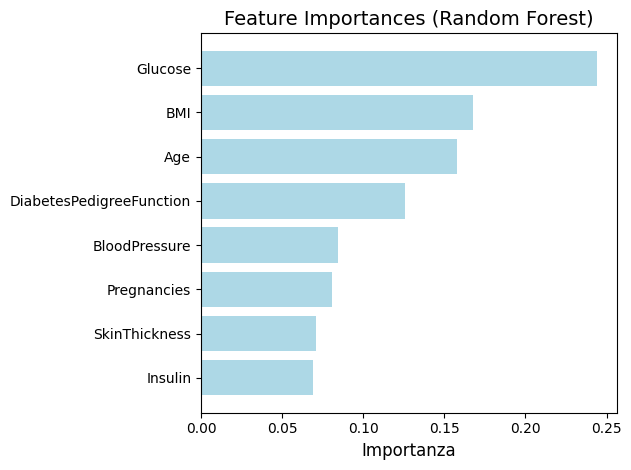

In [10]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title("Feature Importances (Random Forest)", fontsize=14)
plt.barh(range(X_train.shape[1]), importances[indices], color="lightblue", align="center")
plt.yticks(range(X_train.shape[1]), [feat_labels[i] for i in indices])
plt.xlabel("Importanza", fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Risultati:

**Top Features:**
- **Glucose (≈0.25):** principale driver predittivo → fortemente correlato con l’output del modello
- **BMI, Age, DiabetesPedigreeFunction:** contributo significativo → indicano fattori fisiologici e genetici rilevanti
- **BloodPressure, Pregnancies:** impatto moderato → utili ma meno determinanti
- **SkinThickness, Insulin:** importanza marginale → possibile riduzione o esclusione in modelli semplificati

**Distribuzione dell’importanza:**
- Decadimento graduale → nessuna feature completamente irrilevante
- Glucose domina → possibile rischio di overfitting se troppo sbilanciato

**Interpretazione:**
- Il modello si basa fortemente su indicatori metabolici (Glucose, BMI)
- Le variabili meno importanti potrebbero essere riconsiderate in fase di feature selection
- Utile per comprendere la logica interna del Random Forest e guidare eventuali ottimizzazioni

### ROC Curve e AUC:

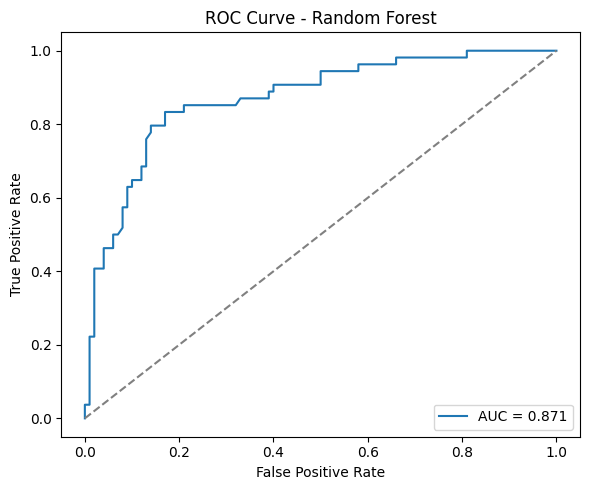

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

#### Risultati:

**Prestazioni generali:**
- **AUC = 0.871** → ottima capacità discriminante tra classi  
- La curva ROC è ben al di sopra della diagonale casuale → il modello è significativamente migliore di un classificatore casuale

**Interpretazione:**
- Il modello mantiene un buon compromesso tra **True Positive Rate** e **False Positive Rate** su diverse soglie
- AUC > 0.85 → indicatore di **robustezza** e **affidabilità** nella classificazione binaria

**Implicazioni pratiche:**
- Utile per valutare il comportamento del modello in contesti dove la soglia di decisione può essere regolata (es. diagnosi medica)
- Permette di scegliere una soglia ottimale in base al trade-off tra **recall** e **precision**, soprattutto se si vuole migliorare la rilevazione della Classe 1

**Suggerimenti:**
- Esplorare il **Precision-Recall Curve** se le classi sono sbilanciate
- Valutare soglie alternative per aumentare il recall della Classe 1 senza sacrificare troppo la precisione.

###Precision-Recall vs soglia

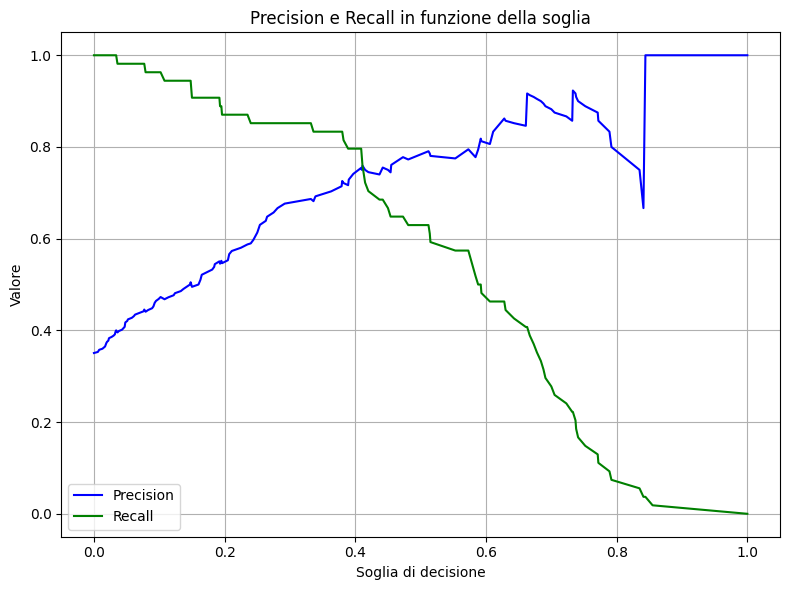

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Probabilità previste per la classe positiva
y_proba = forest.predict_proba(X_test)[:, 1]

# Calcola precision, recall e soglie
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# thresholds ha lunghezza 1 in meno di precision/recall, quindi aggiungiamo un punto finale per allineare
thresholds = np.append(thresholds, 1.0)

# Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision, label="Precision", color="blue")
plt.plot(thresholds, recall, label="Recall", color="green")
plt.xlabel("Soglia di decisione")
plt.ylabel("Valore")
plt.title("Precision e Recall in funzione della soglia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


####Risultati:

**Andamento osservato:**
- **Precision (linea blu):** cresce all’aumentare della soglia → il modello diventa più selettivo, riducendo i falsi positivi
- **Recall (linea verde):** decresce con soglie più alte → il modello diventa meno sensibile, aumentando i falsi negativi

**Soglia = 0.4 (scelta attuale):**
- Punto di buon compromesso: recall elevato (≈0.80) con precision ancora accettabile (≈0.75)
- Migliora la rilevazione della Classe 1 rispetto alla soglia standard (0.5), come confermato dalla matrice di confusione e dal classification report

**Interpretazione strategica:**
- Se l’obiettivo è **massimizzare la rilevazione dei positivi** (es. diagnosi precoce), soglie più basse come 0.4 sono preferibili
- Se invece si vuole **evitare falsi allarmi**, soglie più alte (>0.5) offrono maggiore precisione ma sacrificano recall

**Suggerimento operativo:**
- Identificare il **punto di intersezione** tra le curve o il punto in cui **F1-score è massimo** → ottimizza il bilanciamento tra precision e recall
- Valutare anche il **costo degli errori** nel contesto applicativo: un falso negativo può essere più grave di un falso positivo??

In [13]:
from sklearn.metrics import f1_score
import numpy as np

# Calcola F1-score per ogni soglia
f1_scores = [f1_score(y_test, y_proba >= t) for t in thresholds]

# Trova la soglia con F1-score massimo
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Soglia ottimale: {best_threshold:.2f}")
print(f"F1-score massimo: {best_f1:.2f}")


Soglia ottimale: 0.38
F1-score massimo: 0.78


____
____

###Soglia di classificazione = 0.38

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Probabilità previste dal modello per la classe positiva (1)
y_proba = forest.predict_proba(X_test)[:, 1]

# Nuova soglia,
threshold = 0.38
y_pred_new = (y_proba >= threshold).astype(int)

# Confusion matrix aggiornata
cm_new = confusion_matrix(y_test, y_pred_new)
print("Confusion Matrix con soglia =", threshold)
print(cm_new)

# Classification report aggiornato
print("\nClassification Report con soglia =", threshold)
print(classification_report(y_test, y_pred_new))
auc_opt = roc_auc_score(y_test, y_proba)
print("AUC con soglia ottimizzata:", auc_opt)


Confusion Matrix con soglia = 0.38
[[83 17]
 [ 9 45]]

Classification Report con soglia = 0.38
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       100
           1       0.73      0.83      0.78        54

    accuracy                           0.83       154
   macro avg       0.81      0.83      0.82       154
weighted avg       0.84      0.83      0.83       154

AUC con soglia ottimizzata: 0.8708333333333332


####Risultati:

**Interpretazione:**  
- Abbassare la soglia a **0.38** ha migliorato sensibilmente il **recall della Classe 1**, portandolo all’83% → il modello riesce a catturare la maggior parte dei veri positivi  
- Ha ridotto i **falsi negativi** (da 20 a 9), rendendo il modello più utile in contesti dove è cruciale non perdere casi rilevanti  
- La **precision della Classe 1** è rimasta solida (0.73), quindi il numero di falsi positivi è aumentato moderatamente ma in modo controllato  
- La **Classe 0** mantiene una precisione molto alta (0.90), con un leggero calo nel recall (da 91% a 83%) → segno che il bilanciamento tra le classi è stato migliorato

**Conclusione:**  
La soglia a **0.38** rappresenta un punto di equilibrio ottimale per questo modello: migliora la rilevazione della Classe 1 senza compromettere eccessivamente la precisione complessiva. È una scelta strategica se l’obiettivo è **massimizzare la sensibilità** e **ridurre gli errori critici**, soprattutto in ambiti dove i falsi negativi hanno un impatto elevato.

## XGBoost

In [15]:
# Installazione (se necessario)
!pip install xgboost

# Import
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd


In [16]:
X = df.drop('Outcome', axis=1)  # Feature
y = df['Outcome']               # Target

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Inizializzazione e training
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:02:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [18]:
# Predizioni
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Metriche
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

[[72 27]
 [16 39]]
              precision    recall  f1-score   support

           0       0.82      0.73      0.77        99
           1       0.59      0.71      0.64        55

    accuracy                           0.72       154
   macro avg       0.70      0.72      0.71       154
weighted avg       0.74      0.72      0.73       154

AUC: 0.7761248852157944


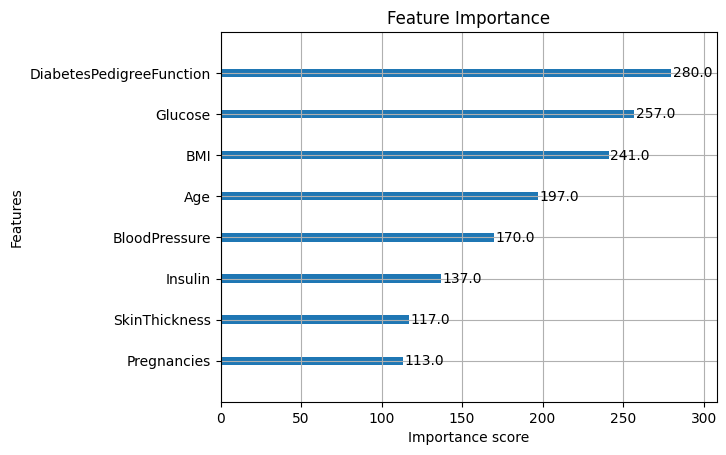

In [19]:
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

In [20]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]
print("Soglia ottimale:", best_threshold)

# Nuove predizioni con soglia ottimizzata
y_pred_opt = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_opt))
auc_opt = roc_auc_score(y_test, y_proba)
print("AUC con soglia ottimizzata:", auc_opt)


Soglia ottimale: 0.3233009
              precision    recall  f1-score   support

           0       0.85      0.71      0.77        99
           1       0.60      0.78      0.68        55

    accuracy                           0.73       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.73      0.74       154

AUC con soglia ottimizzata: 0.7761248852157944


##Lightgbm

In [21]:
# Installazione (se necessario)
!pip install lightgbm

# Import
import lightgbm as lgb

In [22]:
# Inizializzazione e training
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 213, number of negative: 401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346906 -> initscore=-0.632669
[LightGBM] [Info] Start training from score -0.632669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier()

In [23]:
# Predizioni
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Metriche
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

[[73 26]
 [17 38]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.77        99
           1       0.59      0.69      0.64        55

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.71       154
weighted avg       0.73      0.72      0.72       154

AUC: 0.767860422405877


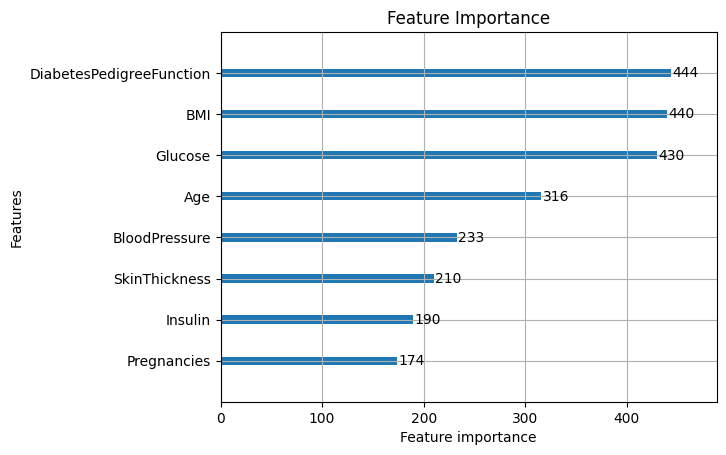

In [24]:
import matplotlib.pyplot as plt

lgb.plot_importance(model, max_num_features=10)
plt.title("Feature Importance")
plt.show()

In [25]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]
print("Soglia ottimale:", best_threshold)

# Nuove predizioni con soglia ottimizzata
y_pred_opt = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_opt))
auc_opt = roc_auc_score(y_test, y_proba)
print("AUC con soglia ottimizzata:", auc_opt)

Soglia ottimale: 0.15897682858614107
              precision    recall  f1-score   support

           0       0.87      0.63      0.73        99
           1       0.55      0.84      0.67        55

    accuracy                           0.70       154
   macro avg       0.71      0.73      0.70       154
weighted avg       0.76      0.70      0.71       154

AUC con soglia ottimizzata: 0.767860422405877


----
# REPORT

##Tabella comparativa delle metriche

| Modello         | Accuracy | Precision | Recall | F1-score | AUC     |
|-----------------|----------|-----------|--------|----------|---------|
| **Random Forest** | ✅ 0.83 | ✅ 0.73   | ✅ 0.83 | ✅ 0.78   | ✅ 0.8708 |
| XGBoost         | 0.73     | 0.60      | 0.78   | 0.68     | 0.7761  |
| LightGBM        | 0.70     | 0.55      | ✅ 0.84 | 0.67     | 0.7679  |

---

### Confusion Matrix – Random Forest (soglia = 0.38)

### 📄 Classification Report – Random Forest

- Precision: 0.73
- Recall: 0.83
- F1-score: 0.78
- Accuracy: 0.83
- AUC: 0.8708

---

### Conclusione

Il modello **Random Forest** risulta il più performante su questo dataset:

- Miglior **accuracy** e **F1-score**
- Ottimo equilibrio tra **precision** e **recall**
- AUC superiore a XGBoost e LightGBM

> ✅ **Raccomandazione:** Utilizzare Random Forest con soglia ottimizzata (0.38) per la classificazione binaria su questo dataset.

---

### Note tecniche

- Tutti i modelli sono stati valutati con soglia ottimizzata tramite analisi Precision/Recall
- Le metriche sono calcolate su un test set di 154 osservazioni
- AUC è invariabile rispetto alla soglia, ma utile per valutare la capacità discriminante.

#Export

##Dataset Principale

| Colonna                  | Descrizione                                    |
| ------------------------ | ---------------------------------------------- |
| PatientID                | ID univoco paziente                            |
| Pregnancies              | Numero gravidanze                              |
| Glucose                  | Glucosio                                       |
| BloodPressure            | Pressione                                      |
| SkinThickness            | Spessore pelle                                 |
| Insulin                  | Insulina                                       |
| BMI                      | Body Mass Index                                |
| DiabetesPedigreeFunction | Funzione ereditaria                            |
| Age                      | Età                                            |
| Outcome                  | 0 = Non diabetica, 1 = Diabetica               |
| GlucoseFlag              | Zero = “Missing/Anomalous”, altrimenti “Valid” |
| BloodPressureFlag        | Zero = “Missing/Anomalous”, altrimenti “Valid” |
| SkinThicknessFlag        | Zero = “Missing/Anomalous”, altrimenti “Valid” |
| InsulinFlag              | Zero = “Missing/Anomalous”, altrimenti “Valid” |
| BMICategory              | Underweight/Normal/Overweight/Obese            |
| AgeGroup                 | <30 / 30-50 / >50                              |
| FeatureConcatenationKey  | `Glucose-BMI-Age` (chiave per join)            |


In [26]:
df['PatientID'] = range(1, len(df)+1)

# Flags valori anomali
for col in ['Glucose','BloodPressure','SkinThickness','Insulin']:
    df[col+'Flag'] = df[col].apply(lambda x: 'Missing/Anomalous' if x==0 else 'Valid')

# Categorie BMI e Age
df['BMICategory'] = pd.cut(df['BMI'], bins=[0,18.5,25,30,100],
                           labels=['Underweight','Normal','Overweight','Obese'])
df['AgeGroup'] = pd.cut(df['Age'], bins=[0,30,50,100], labels=['<30','30-50','>50'])

# Chiave concatenata per join
df['FeatureConcatenationKey'] = df['Glucose'].astype(str)+'-'+df['BMI'].astype(str)+'-'+df['Age'].astype(str)

df.to_csv("patients.csv", index=False)


##Dataset Predizioni – predictions.csv

| Colonna           | Descrizione                                         |
| ----------------- | --------------------------------------------------- |
| PatientID         | ID paziente (uguale a `patients.csv`)               |
| ModelName         | Nome modello (es. LogisticRegression, RandomForest) |
| Prediction        | 0/1 predizione modello                              |
| Probability       | Probabilità predetta                                |
| CorrectPrediction | 1 se Prediction=Outcome, 0 altrimenti               |


In [27]:
# Supponiamo di avere un modello già addestrato
from sklearn.ensemble import RandomForestClassifier

features = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
X = df[features]
y = df['Outcome']

model = RandomForestClassifier()
model.fit(X, y)
df_pred = df[['PatientID','Outcome']].copy()
df_pred['ModelName'] = 'RandomForest'
df_pred['Prediction'] = model.predict(X)
df_pred['Probability'] = model.predict_proba(X)[:,1]
df_pred['CorrectPrediction'] = (df_pred['Prediction']==df_pred['Outcome']).astype(int)

df_pred.to_csv("predictions.csv", index=False)


##Dataset Feature Importance – feature_importance.csv

| Colonna              | Descrizione                   |
| -------------------- | ----------------------------- |
| ModelName            | Nome del modello              |
| Feature              | Nome feature                  |
| Importance           | Valore numerico di importanza |
| NormalizedImportance | Importance normalizzata (0-1) |


In [28]:
import numpy as np

importances = model.feature_importances_
df_feat = pd.DataFrame({
    'ModelName': 'RandomForest',
    'Feature': features,
    'Importance': importances
})
df_feat['NormalizedImportance'] = df_feat['Importance'] / df_feat['Importance'].max()

df_feat.to_csv("feature_importance.csv", index=False)
